<a href="https://colab.research.google.com/github/chigvintseva/UniProject-AST/blob/main/ast_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [468]:
!pip install ace_tools

In [469]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Data generaion

## Main setup

In [470]:
np.random.seed(42)
random.seed(42)

num_people = 150
floors = ['Floor 1', 'Floor 2', 'Floor 3']
timestamps = pd.date_range(start='2025-06-12 09:00:00', periods=60, freq='min')

## Infrastructure coords (based on graphs)

In [471]:
exit_coords = {
    'Floor 1': [(2, 15), (27, 15)],
    'Floor 2': [],
    'Floor 3': []
}

stair_coords = {
    'Floor 1': [(2, 2), (27, 27)],
    'Floor 2': [(2, 2), (27, 27)],
    'Floor 3': [(2, 2), (27, 27)]
}

alarm_coords = {
    'Floor 1': [(2, 28), (28, 2)],
    'Floor 2': [(2, 28), (28, 2)],
    'Floor 3': [(2, 28), (28, 2)]
}

smoke_detectors_coords = {
    'Floor 1': [(10, 10), (10, 20), (20, 10), (20, 20)],
    'Floor 2': [(10, 10), (10, 20), (20, 10), (20, 20)],
    'Floor 3': [(10, 10), (10, 20), (20, 10), (20, 20)]
}

fire_detectors_coords = {
    'Floor 1': [(5, 5), (5, 25), (25, 5), (25, 25)],
    'Floor 2': [(5, 5), (5, 25), (25, 5), (25, 25)],
    'Floor 3': [(5, 5), (5, 25), (25, 5), (25, 25)]
}

crowd_sensors_coords = {
    'Floor 1': [(15, 8), (15, 22)],
    'Floor 2': [(15, 8), (15, 22)],
    'Floor 3': [(15, 8), (15, 22)]
}

## Generation of dataframes with main variables

In [472]:
df = pd.DataFrame({
    'person_id': range(1, num_people + 1),
    'timestamp': np.random.choice(timestamps, num_people),
    'floor': np.random.choice(floors, num_people),
    'location_x': np.random.randint(0, 30, num_people),
    'location_y': np.random.randint(0, 30, num_people),
    'alarm_status': np.random.choice(['OFF', 'ON'], num_people, p=[0.9, 0.1])
})

### Fire centers (will be modified in the future)

In [473]:
fire_centers = {
    'Floor 1': (5, 25),
    'Floor 2': (15, 15),
    'Floor 3': (25, 5)
}


### Smoke level variable generation (based on the fire center in the future)

In [474]:
def compute_smoke_level(row):
    fx, fy = fire_centers[row['floor']]
    dist = np.sqrt((row['location_x'] - fx)**2 + (row['location_y'] - fy)**2)
    return round(np.clip(1 - dist / 30, 0, 1), 2)

In [475]:
df['smoke_level'] = df.apply(compute_smoke_level, axis=1)
df.sort_values(by='timestamp', inplace=True)

## Additional dataset modernisations


In [476]:
if 'panic_factor' not in df.columns:
    df['panic_factor'] = np.clip(np.random.normal(1.0, 0.3, len(df)), 0.5, 2.0)
if 'crowd_sensitivity' not in df.columns:
    df['crowd_sensitivity'] = np.clip(np.random.normal(1.0, 0.2, len(df)), 0.6, 1.4)

In [477]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Data visualisation

## Head and tail

In [478]:
print("\n--- HEAD ---")
print(df.head())
print("\n--- TAIL ---")
print(df.tail())


--- HEAD ---
     person_id           timestamp    floor  location_x  location_y  \
127        128 2025-06-12 09:00:00  Floor 2           0          16   
122        123 2025-06-12 09:00:00  Floor 3           0          28   
82          83 2025-06-12 09:01:00  Floor 2          12          25   
66          67 2025-06-12 09:01:00  Floor 2           7          14   
26          27 2025-06-12 09:01:00  Floor 2          19          11   

    alarm_status  smoke_level  panic_factor  crowd_sensitivity  
127          OFF         0.50      0.760529           1.248394  
122          OFF         0.00      0.598647           0.982847  
82           OFF         0.65      0.902988           0.818061  
66           OFF         0.73      0.501965           1.127725  
26           OFF         0.81      1.518324           1.043172  

--- TAIL ---
     person_id           timestamp    floor  location_x  location_y  \
70          71 2025-06-12 09:59:00  Floor 3           0          19   
102        10

## Bar chart - people per floor

In [479]:
floor_counts = df['floor'].value_counts().sort_index()
floor_df = pd.DataFrame({'floor': floor_counts.index, 'count': floor_counts.values})

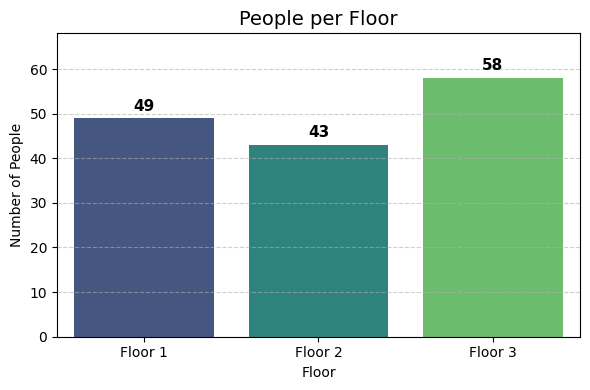

In [480]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=floor_df, x='floor', y='count', hue='floor', palette='viridis', legend=False)

for i, count in enumerate(floor_df['count']):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title("People per Floor", fontsize=14)
plt.xlabel("Floor")
plt.ylabel("Number of People")
plt.ylim(0, max(floor_df['count']) + 10)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Heatmaps

In [481]:
def plot_markers(coords, color, marker, label, size=80):
    for i, (x, y) in enumerate(coords.get(floor, [])):
        if i == 0:
            plt.scatter(x, y, color=color, s=size, marker=marker, label=label)
        else:
            plt.scatter(x, y, color=color, s=size, marker=marker)

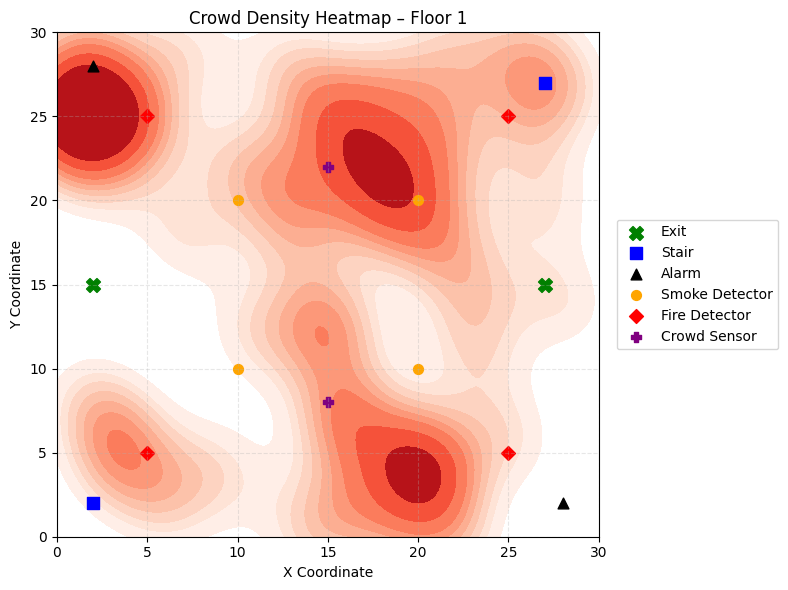

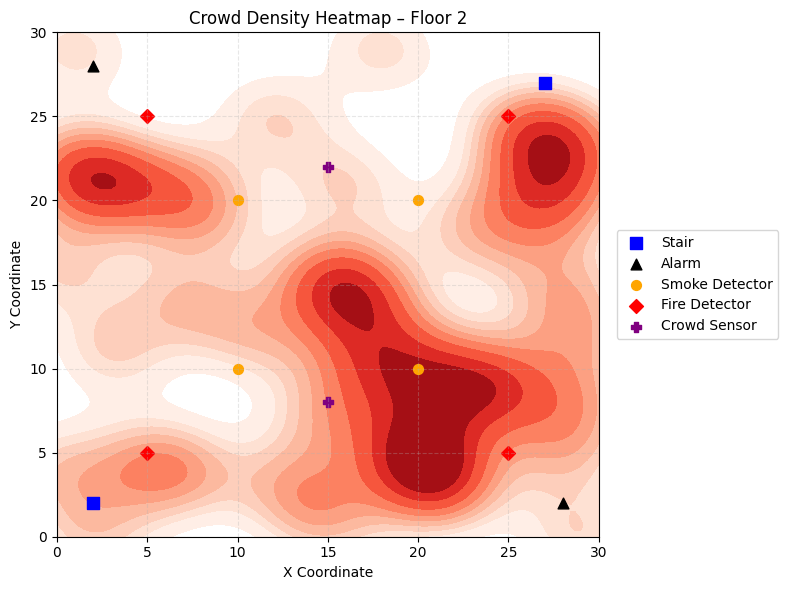

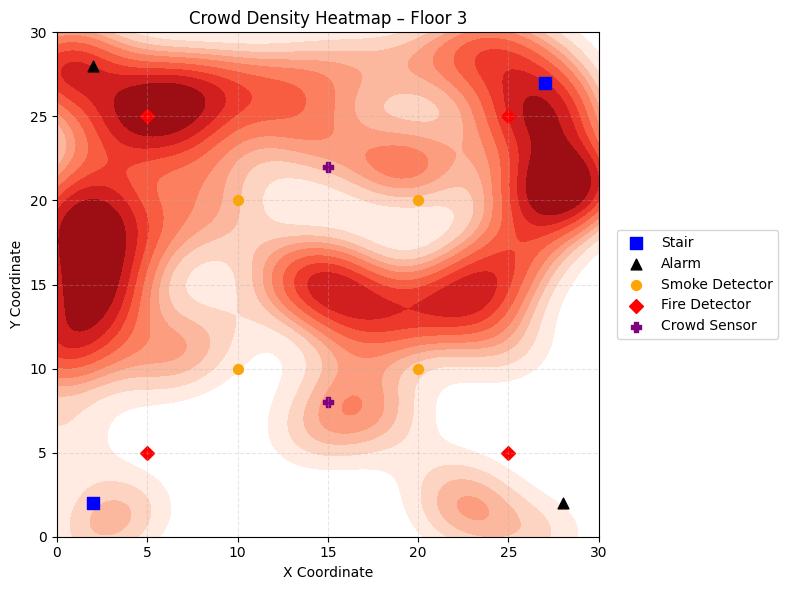

In [482]:

for floor in sorted(df['floor'].unique()):
    plt.figure(figsize=(8, 6))
    df_floor = df[df['floor'] == floor]
    sns.kdeplot(
        x=df_floor['location_x'],
        y=df_floor['location_y'],
        fill=True,
        cmap='Reds',
        bw_adjust=0.5,
        thresh=0.1
    )

    plot_markers(exit_coords, 'green', 'X', 'Exit', 100)
    plot_markers(stair_coords, 'blue', 's', 'Stair', 80)
    plot_markers(alarm_coords, 'black', '^', 'Alarm', 60)
    plot_markers(smoke_detectors_coords, 'orange', 'o', 'Smoke Detector', 50)
    plot_markers(fire_detectors_coords, 'red', 'D', 'Fire Detector', 50)
    plot_markers(crowd_sensors_coords, 'purple', 'P', 'Crowd Sensor', 50)

    plt.title(f'Crowd Density Heatmap – {floor}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

# Simulation

# ABM

### Panic factor - descision making

In [483]:
def make_decision(smoke, panic, sensitivity):
    stress_score = 0.6 * smoke + 0.2 * panic + 0.2 * sensitivity
    irrationality = np.random.rand()
    return irrationality > (stress_score * 0.6)

### Sim function

floor's exit coords should match floor key

In [484]:
def floor_key(floor_str):
    return floor_str if "Floor" in floor_str else f"Floor {floor_str}"

In [502]:
from collections import Counter

crowd_map = Counter()
for _, p in df.iterrows():
    floor = p['floor']
    x, y = p['location_x'], p['location_y']
    if floor != 'Floor 1':
        stairs = stair_coords[floor]
        target_stair = min(stairs, key=lambda c: np.linalg.norm([x - c[0], y - c[1]]))
        crowd_map[tuple(target_stair)] += 1

In [486]:
def simulate_abm(df, scenario='control'):
    results = []
    for _, p in df.iterrows():
        x, y = p['location_x'], p['location_y']
        floor = p['floor']
        smoke = p['smoke_level']
        panic = p['panic_factor']
        sens = p['crowd_sensitivity']

        if floor == 'Floor 1':
            exits = exit_coords['Floor 1']
            target = min(exits, key=lambda c: np.linalg.norm([x - c[0], y - c[1]]))
            total_dist = np.linalg.norm([x - target[0], y - target[1]])
        else:
            stairs = stair_coords[floor]
            stair_target = min(
                stairs,
                key=lambda c: crowd_map[tuple(c)] + np.linalg.norm([x - c[0], y - c[1]])
            )
            dist_to_stair = np.linalg.norm([x - stair_target[0], y - stair_target[1]])
            exit_target = min(exit_coords['Floor 1'], key=lambda c: np.linalg.norm([
                stair_target[0] - c[0], stair_target[1] - c[1]
            ]))
            dist_to_exit = np.linalg.norm([
                stair_target[0] - exit_target[0], stair_target[1] - exit_target[1]
            ])
            total_dist = dist_to_stair + dist_to_exit

        speed = max(0.4, 3.0 / panic)
        if 'congestion' in scenario:
            speed *= (1 - min(0.5, sens * 0.3))
        if 'stress' in scenario:
            speed *= (1 - smoke * 0.4)
        if floor != 'Floor 1':
            density_penalty = min(0.3, 0.05 * crowd_map[tuple(stair_target)])
            speed *= (1 - density_penalty)


        if not make_decision(smoke, panic, sens):
            evac_time = 999
            evac = False
        else:
             evac_time = int(total_dist / speed) + random.randint(3, 15)
             evac = evac_time < 400

        results.append({
            'person_id': p['person_id'],
            'floor': floor,
            'evacuation_time': evac_time,
            'evacuated': evac,
            'fatal': not evac,
            'scenario': f'ABM {scenario.capitalize()}'
        })

    return pd.DataFrame(results)

# DES

In [487]:
def simulate_des(df, scenario='control'):
    results = []
    for _, p in df.iterrows():
        x, y = p['location_x'], p['location_y']
        floor = p['floor']
        smoke = p['smoke_level']
        panic = p['panic_factor']

        delay = 0
        if scenario == 'fixed':
            delay = 30 if p['alarm_status'] == 'OFF' else 0
        elif scenario == 'smoke':
            delay = int(15 + smoke * 40) if p['alarm_status'] == 'OFF' else 0
        elif scenario == 'broken':
            delay = 999

        if floor == 'Floor 1':
            exit_target = min(exit_coords['Floor 1'], key=lambda c: np.linalg.norm([x - c[0], y - c[1]]))
            dist = np.linalg.norm([x - exit_target[0], y - exit_target[1]])
        else:
            stair_target = min(stair_coords[floor], key=lambda c: np.linalg.norm([x - c[0], y - c[1]]))
            dist_to_stair = np.linalg.norm([x - stair_target[0], y - stair_target[1]])
            exit_target = min(exit_coords['Floor 1'], key=lambda c: np.linalg.norm([
                stair_target[0] - c[0], stair_target[1] - c[1]
            ]))
            dist_to_exit = np.linalg.norm([
                stair_target[0] - exit_target[0], stair_target[1] - exit_target[1]
            ])
            dist = dist_to_stair + dist_to_exit

        base_speed = max(0.3, 1.8 - panic)
        movement_time = int(dist / base_speed) + random.randint(30, 90)
        evac_time = delay + movement_time
        evac = evac_time < 300

        results.append({
            'person_id': p['person_id'],
            'floor': floor,
            'evacuation_time': evac_time,
            'evacuated': evac,
            'fatal': not evac,
            'scenario': f'DES {scenario.capitalize()}'
        })

    return pd.DataFrame(results)

# Run of simulations

In [488]:
abm_control = simulate_abm(df, 'control')
abm_congestion = simulate_abm(df, 'congestion')
abm_stress = simulate_abm(df, 'stress')
abm_combined = simulate_abm(df, 'combined')

des_control = simulate_des(df, 'control')
des_fixed = simulate_des(df, 'fixed')
des_smoke = simulate_des(df, 'smoke')
des_broken = simulate_des(df, 'broken')

# KPIs collection and Validation

In [489]:
all_sim = pd.concat([
    abm_control, abm_congestion, abm_stress, abm_combined,
    des_control, des_fixed, des_smoke, des_broken
])

In [490]:
kpi = all_sim.groupby(['scenario', 'floor']).agg(
    avg_time=('evacuation_time', 'mean'),
    total_people=('person_id', 'count'),
    fatalities=('fatal', 'sum'),
    evacuated=('evacuated', 'sum')
)
kpi['evac_rate'] = kpi['evacuated'] / kpi['total_people']

In [491]:
print("Validation (expected avg evac time ~150s):")
for scenario in all_sim['scenario'].unique():
    subset = all_sim[all_sim['scenario'] == scenario]
    print(f"{scenario}: avg_time = {subset['evacuation_time'].mean():.2f}, \
    fatality rate = {1 - subset['evacuated'].mean():.2%}")

Validation (expected avg evac time ~150s):
ABM Control: avg_time = 358.02,     fatality rate = 34.67%
ABM Congestion: avg_time = 419.63,     fatality rate = 40.67%
ABM Stress: avg_time = 398.82,     fatality rate = 38.67%
ABM Combined: avg_time = 456.42,     fatality rate = 44.67%
DES Control: avg_time = 90.63,     fatality rate = 0.00%
DES Fixed: avg_time = 120.51,     fatality rate = 0.00%
DES Smoke: avg_time = 123.78,     fatality rate = 0.00%
DES Broken: avg_time = 1090.77,     fatality rate = 100.00%


# Visualisation

## Bar chart of av. evacuation time

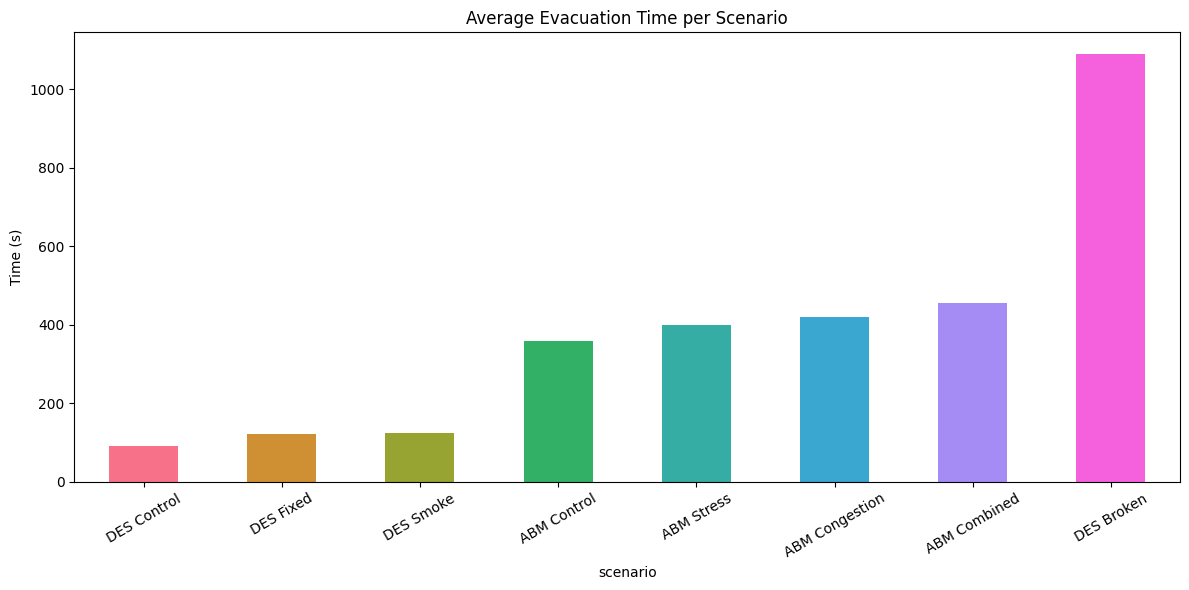

In [492]:
plt.figure(figsize=(12, 6))
kpi_avg = all_sim.groupby('scenario')['evacuation_time'].mean().sort_values()
kpi_avg.plot(kind='bar', title='Average Evacuation Time per Scenario', ylabel='Time (s)', color=sns.color_palette('husl', len(kpi_avg)))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Evacuation rate heatmap

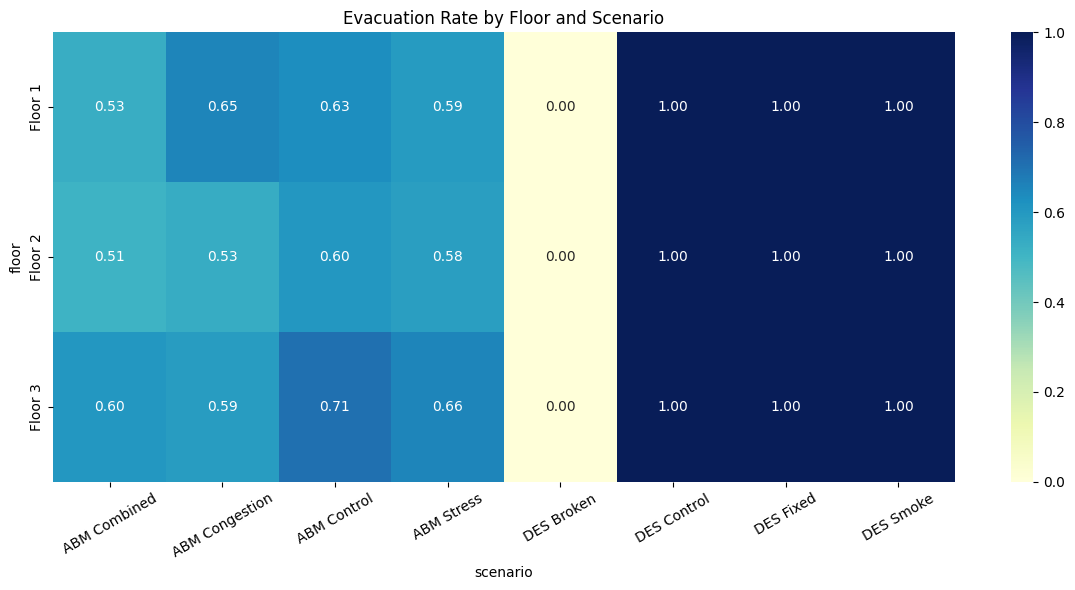

In [493]:
plt.figure(figsize=(12, 6))
kpi_floor = kpi.reset_index().pivot(index='floor', columns='scenario', values='evac_rate')
sns.heatmap(kpi_floor, annot=True, cmap='YlGnBu', fmt=".2f")
plt.xticks(rotation=30)
plt.title("Evacuation Rate by Floor and Scenario")
plt.tight_layout()
plt.show()

## Fatality bar chart

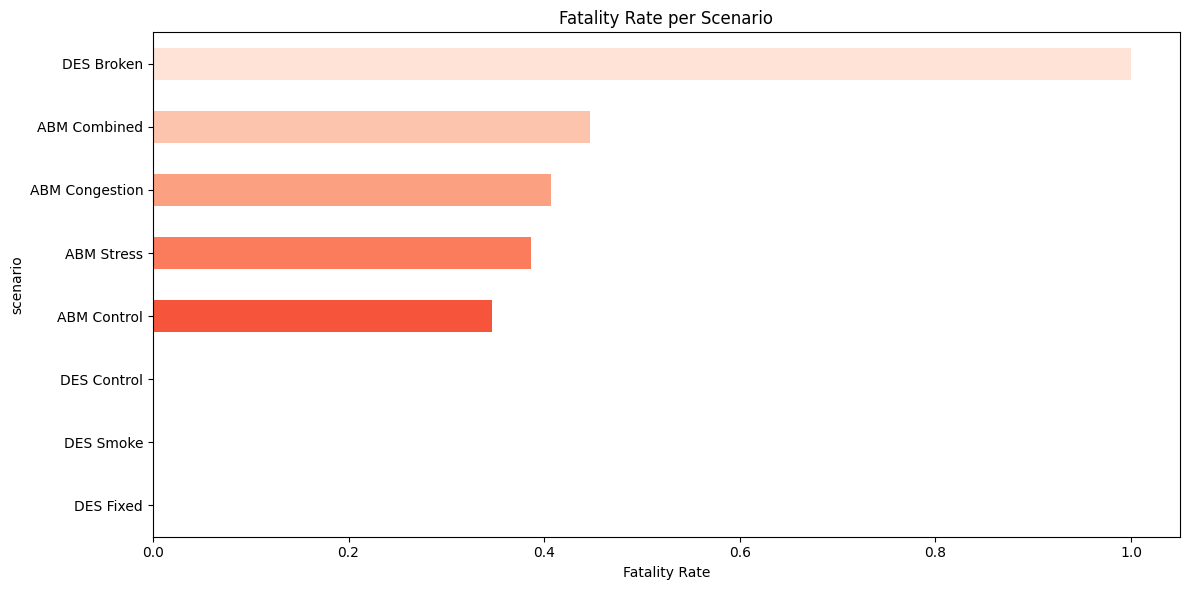

In [494]:
plt.figure(figsize=(12, 6))
kpi_fatal = all_sim.groupby('scenario')['fatal'].mean().sort_values()
kpi_fatal.plot(kind='barh', color=sns.color_palette('Reds_r', len(kpi_fatal)))
plt.title("Fatality Rate per Scenario")
plt.xlabel("Fatality Rate")
plt.tight_layout()
plt.show()

## Total evacuated, pie chart

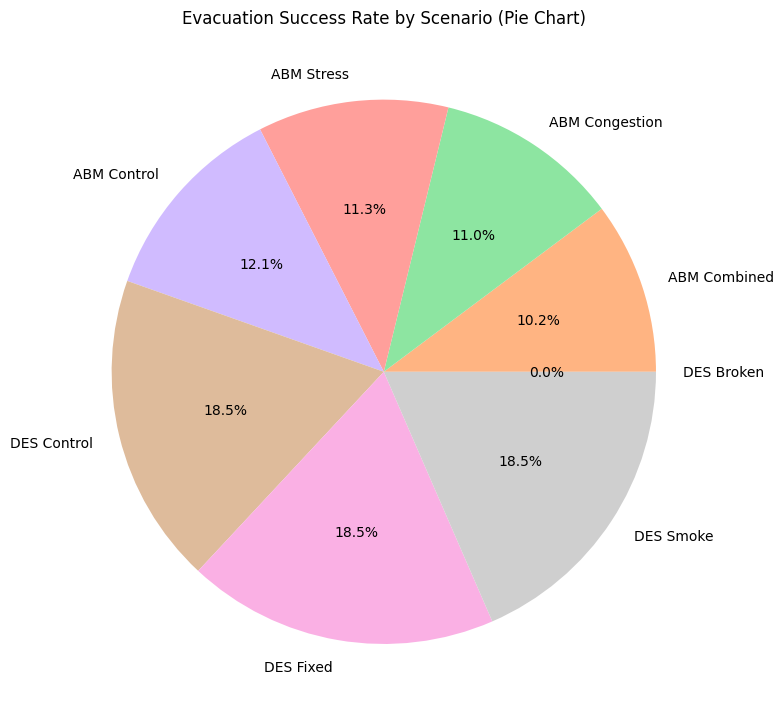

In [495]:
plt.figure(figsize=(8, 8))
pie_data = all_sim.groupby('scenario')['evacuated'].mean().sort_values()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Evacuation Success Rate by Scenario (Pie Chart)")
plt.tight_layout()
plt.show()

## Total evacuated, bar chart

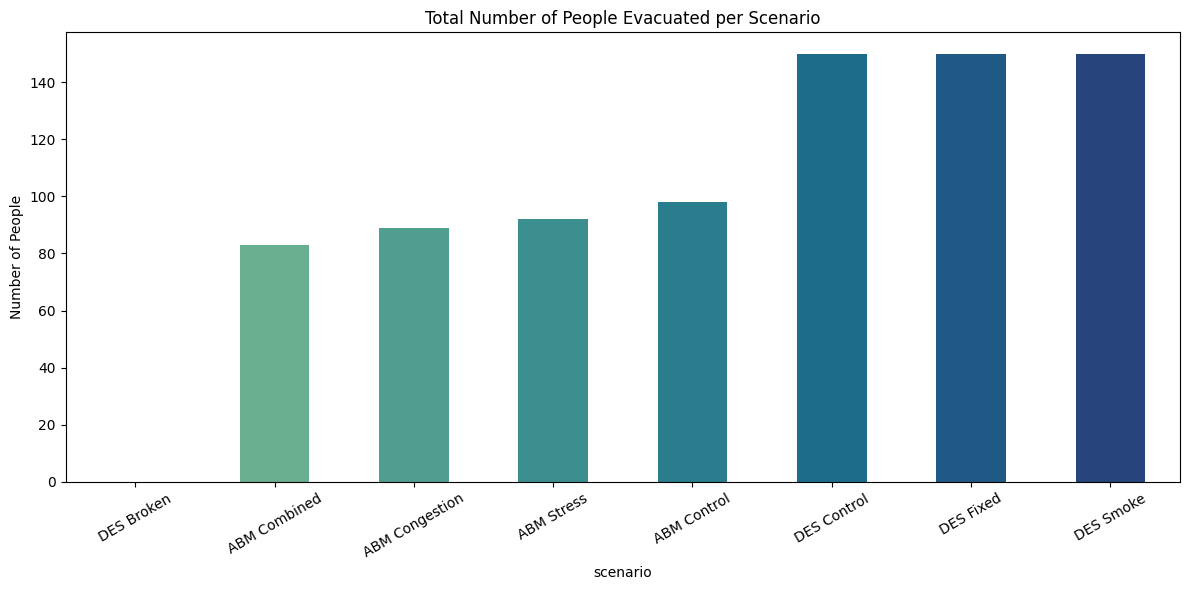

In [496]:
plt.figure(figsize=(12, 6))
kpi_evac = all_sim.groupby('scenario')['evacuated'].sum().sort_values()
kpi_evac.plot(kind='bar', color=sns.color_palette('crest', len(kpi_evac)))
plt.title("Total Number of People Evacuated per Scenario")
plt.ylabel("Number of People")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Time, heatmap, in minutes

In [497]:
total_times = (
    all_sim[all_sim['evacuated']]
    .groupby('scenario')['evacuation_time']
    .sum()
    .div(60)
    .sort_values()
    .reset_index()
)

In [498]:
heatmap_data = pd.DataFrame(
    [total_times['evacuation_time'].values],
    columns=total_times['scenario'].astype(str)
)

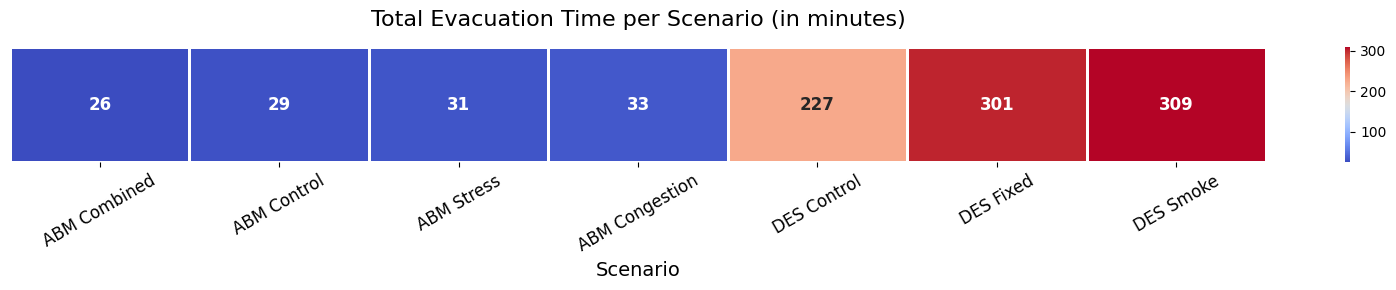

In [499]:
plt.figure(figsize=(16, 3))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    annot_kws={"size": 12, "weight": "bold"},
    cmap="coolwarm",
    cbar=True,
    linewidths=2,
    linecolor='white',
    xticklabels=True,
    yticklabels=False
)


plt.title("Total Evacuation Time per Scenario (in minutes)", fontsize=16, pad=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30)
ax.set_xlabel("Scenario", fontsize=14)
plt.tight_layout()
plt.show()

## Box plot, individual scenarious

In [500]:
colors = sns.color_palette("viridis", n_colors=len(all_sim['scenario'].unique()))

kpi_max = all_sim.groupby('scenario')['evacuation_time'].max().sort_values()

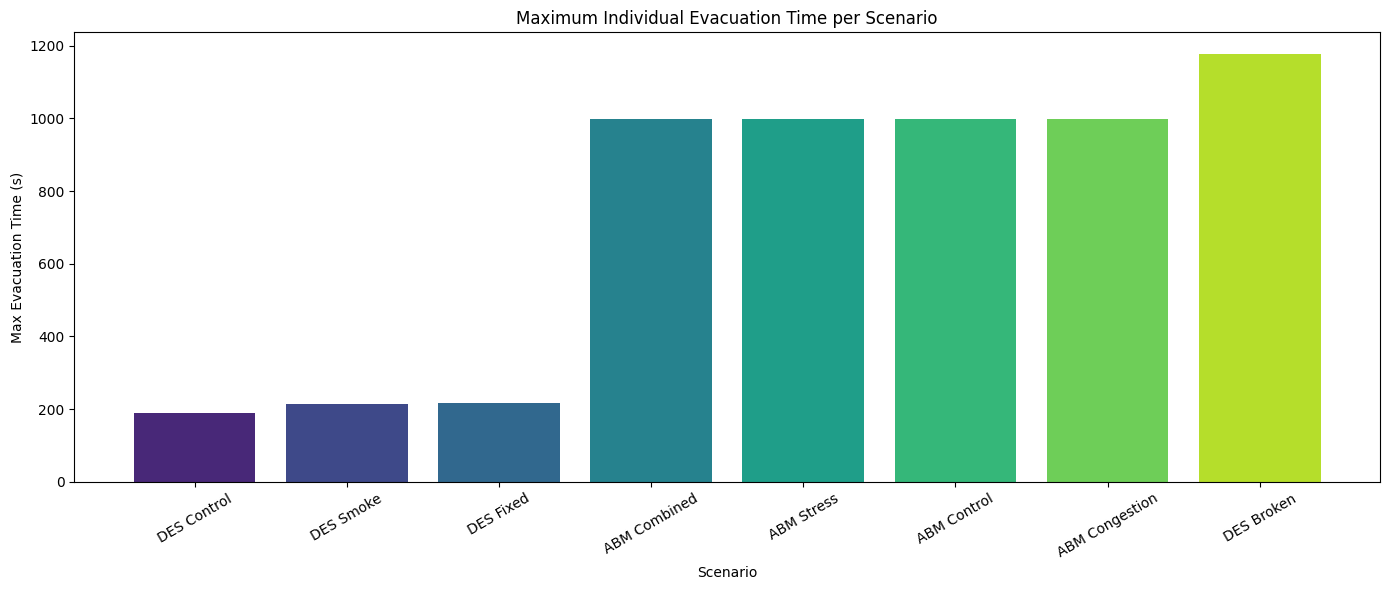

In [501]:
plt.figure(figsize=(14, 6))
plt.bar(kpi_max.index.astype(str), kpi_max.values, color=colors)
plt.title("Maximum Individual Evacuation Time per Scenario")
plt.ylabel("Max Evacuation Time (s)")
plt.xlabel("Scenario")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()